# Quality Assurance (QA) Tutorial

This notebook gives example uses of image based QA metrics in `ukat`.

We'll start with some imports and general housekeeping

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.qa import snr

# Initialise output path for QA
directory = 'qa_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

## Image Signal to Noise Ratio (iSNR)
There is no standardised method to measure iSNR within the MRI community, as such `ukat` simply aims to provide a highly repeatable method that allows for a direct comparison between acquisitions rather than a comparison between different
studies/modalities. A concise introduction to iSNR measurements in MRI can be found [here](http://mriquestions.com/signal-to-noise.html).

We'll start off by loading some T2W structural data.

(-0.5, 255.5, -0.5, 255.5)

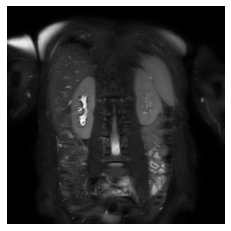

In [2]:
# Fetch data
data, affine = fetch.t2w_volume_philips()
fig, ax = plt.subplots()
ax.imshow(data[:,:,7].T, origin='lower', cmap='gray')
ax.axis(False)

The iSNR calculation `ukat` performs is $\textrm{iSNR} = \frac{Mean\left(\textrm{Foreground Voxels}\right)}{\sigma\left
(\textrm{Background Voxels}\right)}$. To do this we need to segment the image into background and foreground voxels. This
mask can either be supplied manually or estimated by the `Isnr` class. Lets start by demonstrating the simplest way the
`Isnr` class can work before exploring the automatic background segmentation in more depth.

In [3]:
isnr = snr.Isnr(data).isnr
print(f'This image has an iSNR of {isnr:.2f}.')

This image has an iSNR of 45.97.


The automatic background segmentation uses a Bayesian Gaussian mixture model to assign each voxel to a cluster of similar
intensities. The cluster with the lowest mean is assumed to be the background. As a very rough rule of thumb, dividing the
image into three clusters works quite well as this results in a background cluster, a dark foreground cluster and a bright
foreground cluster. The number of clusters can be adjusted when calling `Isnr`.

Text(0.5, 1.0, 'Four Clusters')

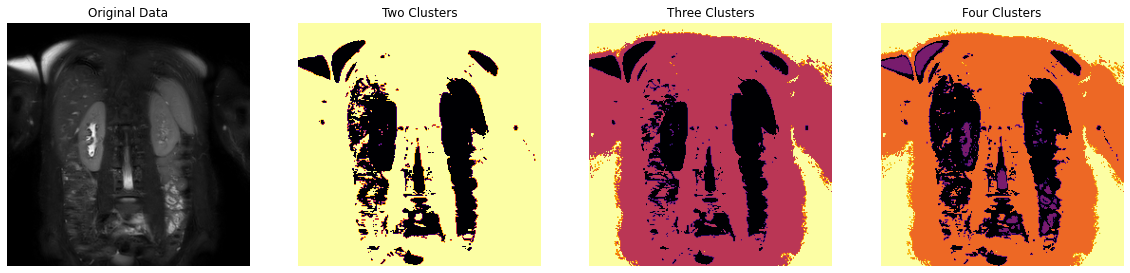

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(data[:,:,7].T, origin='lower', cmap='gray')
ax[0].axis(False)
ax[0].set_title('Original Data')

isnr_obj = snr.Isnr(data, n_clusters=2)
ax[1].imshow(isnr_obj.clusters[:,:,7].T, origin='lower', cmap='inferno_r')
ax[1].axis(False)
ax[1].set_title('Two Clusters')

isnr_obj = snr.Isnr(data, n_clusters=3)
ax[2].imshow(isnr_obj.clusters[:,:,7].T, origin='lower', cmap='inferno_r')
ax[2].axis(False)
ax[2].set_title('Three Clusters')

isnr_obj = snr.Isnr(data, n_clusters=4)
ax[3].imshow(isnr_obj.clusters[:,:,7].T, origin='lower', cmap='inferno_r')
ax[3].axis(False)
ax[3].set_title('Four Clusters')

The background mask can also be viewed, its is important to verify the segmentation is working as expected when using `Isnr`
 with a new sequence.

Text(0.5, 0.98, 'T2* iSNR = 17.10.')

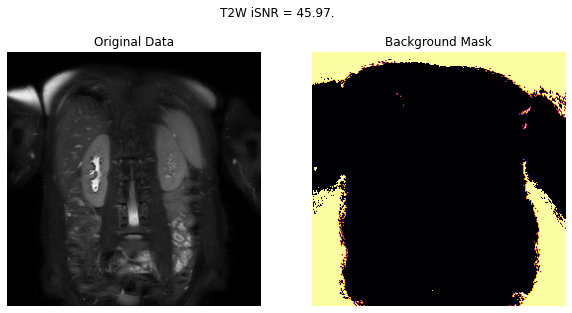

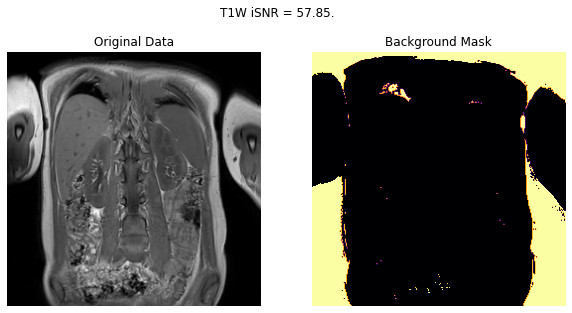

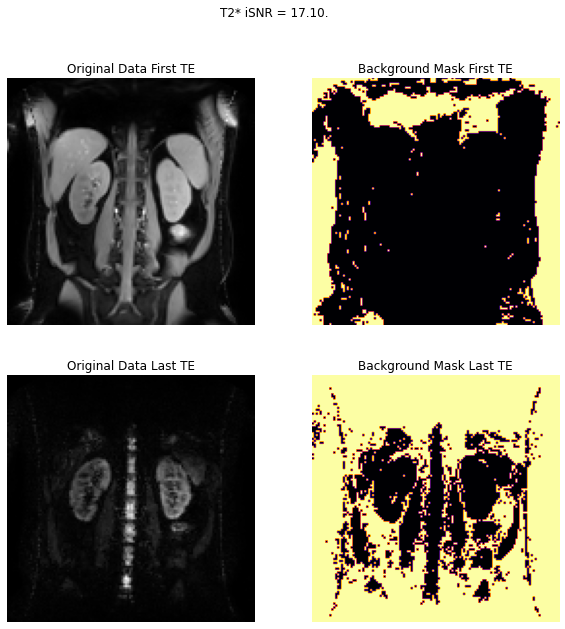

In [5]:
# T2W data
data, affine = fetch.t2w_volume_philips()
isnr_obj = snr.Isnr(data, n_clusters=3)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data[:,:,7].T, origin='lower', cmap='gray')
ax[0].axis(False)
ax[0].set_title('Original Data')

ax[1].imshow(isnr_obj.noise_mask[:,:,7].T, origin='lower', cmap='inferno')
ax[1].axis(False)
ax[1].set_title('Background Mask')

fig.suptitle(f'T2W iSNR = {isnr_obj.isnr:.2f}.')

# T1W data
data, affine = fetch.t1w_volume_philips()
isnr_obj = snr.Isnr(data, n_clusters=3)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data[:,:,7].T, origin='lower', cmap='gray')
ax[0].axis(False)
ax[0].set_title('Original Data')

ax[1].imshow(isnr_obj.noise_mask[:,:,7].T, origin='lower', cmap='inferno')
ax[1].axis(False)
ax[1].set_title('Background Mask')

fig.suptitle(f'T1W iSNR = {isnr_obj.isnr:.2f}.')

#T2* data
data, affine, te = fetch.t2star_philips()
isnr_obj = snr.Isnr(data, n_clusters=3)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(data[:,:,3, 0].T, origin='lower', cmap='gray')
ax[0, 0].axis(False)
ax[0, 0].set_title('Original Data First TE')

ax[0, 1].imshow(isnr_obj.noise_mask[:,:,3, 0].T, origin='lower', cmap='inferno')
ax[0, 1].axis(False)
ax[0, 1].set_title('Background Mask First TE')

ax[1, 0].imshow(data[:,:,3, -1].T, origin='lower', cmap='gray')
ax[1, 0].axis(False)
ax[1, 0].set_title('Original Data Last TE')

ax[1, 1].imshow(isnr_obj.noise_mask[:,:,3, -1].T, origin='lower', cmap='inferno')
ax[1, 1].axis(False)
ax[1, 1].set_title('Background Mask Last TE')

fig.suptitle(f'T2* iSNR = {isnr_obj.isnr:.2f}.')

## Temporal Signal to Noise Ratio (tSNR)
Here we will use two datasets as examples of high and low tSNR. Both are FAIR ASL sequences however the high tSNR data was
acquired a body coil while the low tSNR data was acquired using the receive coil built into the bore of the magnet. Additional Gaussian noise was also added to the low tSNR data.

Each dataset will be fetched, a tSNR map calculated and the output saved as a nifti. The resulting tSNR maps will also be displayed in this notebook.

(-0.5, 111.5, 111.5, -0.5)

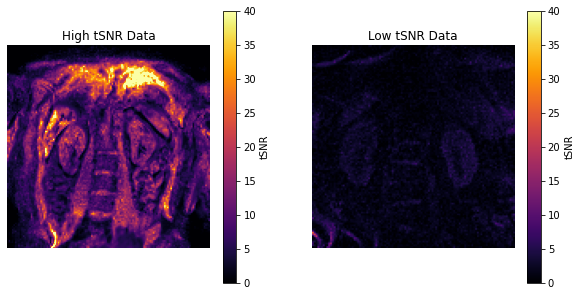

In [6]:
# Fetch data
high_tsnr_data, high_tsnr_affine = fetch.tsnr_high_philips()
# Calculate tSNR map
high_tsnr_obj = snr.Tsnr(high_tsnr_data, high_tsnr_affine)
# Save as nifti
high_tsnr_obj.to_nifti(OUTPUT_DIR, 'high_quality_data')

# Process low tSNR data in the same way
low_tsnr_data, low_tsnr_affine = fetch.tsnr_low_philips()
low_tsnr_obj = snr.Tsnr(low_tsnr_data, low_tsnr_affine)
low_tsnr_obj.to_nifti(OUTPUT_DIR, 'low_quality_data')

# Display both tSNR maps in the same figure with the same colour scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(np.rot90(high_tsnr_obj.tsnr_map[:, :, 2]), cmap='inferno', clim=(0, 40))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('tSNR')
ax1.set_title('High tSNR Data')
ax1.axis('off')

im = ax2.imshow(np.rot90(low_tsnr_obj.tsnr_map[:, :, 2], -1), cmap='inferno', clim=(0, 40))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('tSNR')
ax2.set_title('Low tSNR Data')
ax2.axis('off')